In [34]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2 as cv
from tqdm.notebook import tqdm
from tensorflow.python.client import device_lib
import pickle

listOfDevices = device_lib.list_local_devices()
for device in listOfDevices:
    if(device.device_type == "GPU"):
        print(device)


name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10514789824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15821817099809523748
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"



# Download Dataset
Run the codes of this section only one time, it will downlad and store the dataset in your drive

### Reading datasets
First, reading datasets and see everthing is working fine.

In [35]:
def pathTo(path):
    return "./data/"+path

trainList = []
testList = []
classNames = []

with open(pathTo("annot_train.csv"), 'r') as file:
    trainList = pd.read_csv(file)

with open(pathTo("annot_test.csv"), 'r') as file:
    testList = pd.read_csv(file)

with open(pathTo("class_names.csv"), 'r') as file:
    classNames = file.readline().split(',')
print(len(classNames))
trainList.head()

196


,im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,car_ims/000001.jpg,112,7,853,717,1
1,car_ims/000002.jpg,48,24,441,202,1
2,car_ims/000003.jpg,7,4,277,180,1
3,car_ims/000004.jpg,33,50,197,150,1
4,car_ims/000005.jpg,5,8,83,58,1


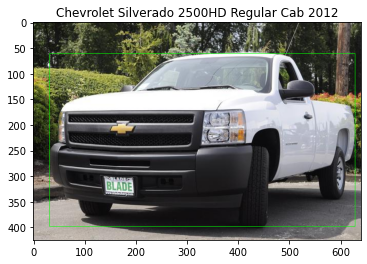

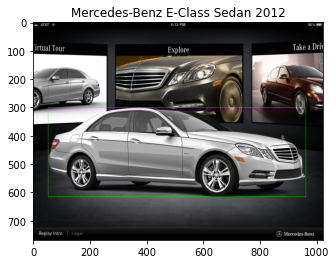

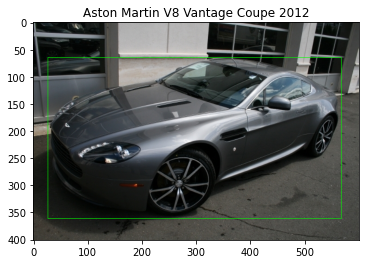

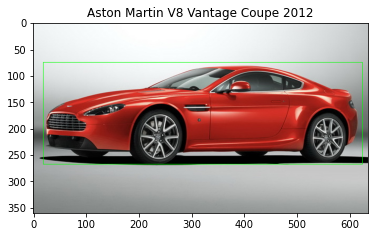

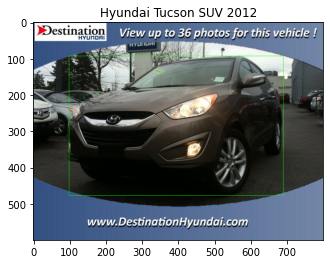

In [38]:
for i in tqdm(np.random.randint(0, len(trainList), 5)):
    classId = trainList['class'][i]
    image = cv.imread(pathTo(trainList['im_path'][i]))
    x1 = trainList['bbox_x1'][i]
    y1 = trainList['bbox_y1'][i]
    x2 = trainList['bbox_x2'][i]
    y2 = trainList['bbox_y2'][i]
    image = cv.rectangle(image, (x1,y1), (x2,y2), (0,255,0), 1)
    plt.figure()
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(classNames[classId-1])

# part 1
As you know working with large datasets on ML is a little trickky, if you load all the data on you computers memory, it will ends up with memory starving and can't process any more. A common method is to use a data **Generator** which loads only that parts of the data which is needed at a specific time and all the rest will be remained at the storage till we need them. At this part, i want you to write a Generator class which can handle this issue. 

(64, 224, 224, 3)
(64, 196)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


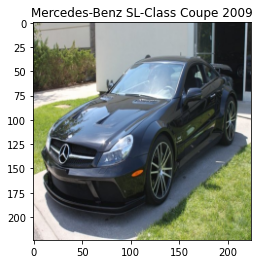

In [5]:
class Generator(keras.utils.Sequence):
    def __init__(self, data, labels, batchSize=64,\
                 dim=(224, 224), nChannels=3, nClasses=196, shuffle=True):
        self.dim = dim
        self.batchSize = batchSize
        self.labels = labels
        self.data = data
        self.nChannels = nChannels
        self.nClasses = nClasses
        self.shuffle = shuffle
        self.onEpochEnd()
    
    def onEpochEnd(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batchSize))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batchSize:(index+1)*self.batchSize]

        # Generate data
        X, Y = self.__dataGeneration(indexes)

        return X, Y
    
    def __dataGeneration(self, indexes):
        'Generates data containing batch_size samples'
        # X : (n_samples, *dim, n_channels)
        
        # Initialization
        X = np.empty((self.batchSize, * self.dim, self.nChannels), dtype=int)
        Y = np.empty((self.batchSize), dtype=int)

        # Generate data
        for i in range(self.batchSize):
            path = self.data[indexes[i]]
            img = cv.imread(pathTo(path))
            img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            X[i,] = img
            Y[i] = self.labels[indexes[i]]

        return X, keras.utils.to_categorical(Y, num_classes=self.nClasses)
    

trainX = trainList.to_numpy()[:,0]
trainY = trainList.to_numpy()[:,-1] - 1

trainingGenerator = Generator(trainX, trainY)
X, Y = trainingGenerator[0]
print(X.shape)
print(Y.shape)
img = X[20]
className = np.argmax(Y[20])
print(Y[30])

plt.imshow(img)
plt.title(classNames[className])
plt.show()

# Part 2
Using pretrained Resnet50 with stocastic weghits, train the model for classification with the training set and represent the resualts as accuracy score on test dataset.

In [8]:
from sklearn.model_selection import train_test_split

trainX = trainList.to_numpy()[:,0]
trainY = trainList.to_numpy()[:,-1] - 1

trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=0.1, random_state=1)

trainingGenerator = Generator(trainX, trainY)
validationGenerator = Generator(validX, validY)

model = keras.applications.ResNet50(input_shape=(224,224,3), classes=196, weights=None)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(generator=trainingGenerator, validation_data=validationGenerator, epochs=10, use_multiprocessing=True, workers=-1)


Epoch 1/10
114/114 [==============================] - 112s 984ms/step - loss: 5.8021 - accuracy: 0.0058 - val_loss: 24.6774 - val_accuracy: 0.0039
Epoch 2/10
114/114 [==============================] - 106s 928ms/step - loss: 5.3028 - accuracy: 0.0133 - val_loss: 5.2337 - val_accuracy: 0.0104
Epoch 3/10
114/114 [==============================] - 105s 923ms/step - loss: 5.2090 - accuracy: 0.0127 - val_loss: 5.2235 - val_accuracy: 0.0078
Epoch 4/10
114/114 [==============================] - 105s 924ms/step - loss: 5.1747 - accuracy: 0.0138 - val_loss: 6.5993 - val_accuracy: 0.0039
Epoch 5/10
114/114 [==============================] - 105s 920ms/step - loss: 5.1012 - accuracy: 0.0178 - val_loss: 16.8430 - val_accuracy: 0.0039
Epoch 6/10
114/114 [==============================] - 105s 920ms/step - loss: 5.0128 - accuracy: 0.0221 - val_loss: 10.2991 - val_accuracy: 0.0065
Epoch 7/10
114/114 [==============================] - 105s 925ms/step - loss: 4.8939 - accuracy: 0.0311 - val_loss: 5.202


(8041, 224, 224, 3)
Accuracy is: 0.04


Text(0.5, 1.0, 'Confusion matrix')

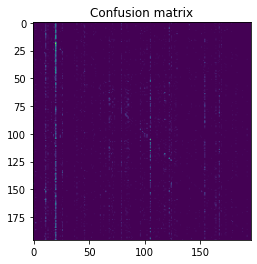

In [47]:
import sklearn.metrics
testX = testList.to_numpy()[:,0]
testY = testList.to_numpy()[:,-1] - 1

testY = keras.utils.to_categorical(testY, num_classes=196)

X = []
for path in tqdm(testX):
    img = cv.imread(pathTo(path))
    img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    X += [img]
    
X = np.array(X)
print(X.shape)

predY = model.predict(X)
predY = np.argmax(predY, axis=1)
trueY = np.argmax(testY, axis=1)

conf = sklearn.metrics.confusion_matrix(trueY, predY, normalize=None)
accuracy = sklearn.metrics.accuracy_score(trueY, predY)

print("Accuracy is: %0.2f" % (accuracy))
plt.imshow(conf)
plt.title("Confusion matrix")

# Part 3
Using pretrained model of Resnet50 model on ImageNet, predict the lables of test set and represent the resualts as above.

In [48]:
from sklearn.model_selection import train_test_split

trainX = trainList.to_numpy()[:,0]
trainY = trainList.to_numpy()[:,-1] - 1

trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=0.1, random_state=1)

trainingGenerator = Generator(trainX, trainY)
validationGenerator = Generator(validX, validY)

model= keras.applications.ResNet50(input_shape=(224,224,3),classes=196,weights='imagenet',include_top=False)
x = keras.layers.GlobalAvgPool2D()(model.output)
x = keras.layers.Dense(units=196,activation='softmax')(x) 
model = keras.models.Model(model.input, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(generator=trainingGenerator, validation_data=validationGenerator, epochs=10, use_multiprocessing=True, workers=-1)


Epoch 1/10
114/114 [==============================] - 106s 929ms/step - loss: 5.0826 - accuracy: 0.0252 - val_loss: 109.8083 - val_accuracy: 0.0052
Epoch 2/10
114/114 [==============================] - 105s 920ms/step - loss: 3.6232 - accuracy: 0.1587 - val_loss: 7.9746 - val_accuracy: 0.0326
Epoch 3/10
114/114 [==============================] - 105s 921ms/step - loss: 2.1555 - accuracy: 0.4241 - val_loss: 3.7940 - val_accuracy: 0.1589
Epoch 4/10
114/114 [==============================] - 105s 925ms/step - loss: 1.1216 - accuracy: 0.6764 - val_loss: 3.5426 - val_accuracy: 0.3021
Epoch 5/10
114/114 [==============================] - 107s 938ms/step - loss: 0.5069 - accuracy: 0.8532 - val_loss: 3.2756 - val_accuracy: 0.2865
Epoch 6/10
114/114 [==============================] - 110s 965ms/step - loss: 0.2366 - accuracy: 0.9349 - val_loss: 2.6255 - val_accuracy: 0.4141
Epoch 7/10
114/114 [==============================] - 109s 957ms/step - loss: 0.1440 - accuracy: 0.9640 - val_loss: 2.9624


(8041, 224, 224, 3)
Accuracy is: 0.38


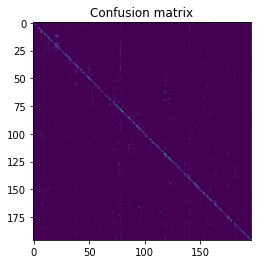

In [49]:
import sklearn.metrics
testX = testList.to_numpy()[:,0]
testY = testList.to_numpy()[:,-1] - 1

testY = keras.utils.to_categorical(testY, num_classes=196)

X = []
for path in tqdm(testX):
    img = cv.imread(pathTo(path))
    img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    X += [img]
    
X = np.array(X)
print(X.shape)

predY = model.predict(X)
predY = np.argmax(predY, axis=1)
trueY = np.argmax(testY, axis=1)

conf = sklearn.metrics.confusion_matrix(trueY, predY, normalize=None)
accuracy = sklearn.metrics.accuracy_score(trueY, predY)

print("Accuracy is: %0.2f" % (accuracy))
plt.imshow(conf)
plt.title("Confusion matrix")
plt.show()

# part 4
Including image admentation method on images and retrain the pretrained resnet on ImageNet datase.

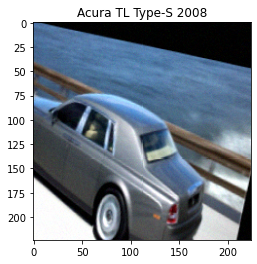

In [23]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

class Generator(keras.utils.Sequence):
    def __init__(self, data, labels, batchSize=64,\
                 dim=(224, 224), nChannels=3, nClasses=196, shuffle=True):
        ia.seed(1)
        self.dim = dim
        self.batchSize = batchSize
        self.labels = labels
        self.data = data
        self.nChannels = nChannels
        self.nClasses = nClasses
        self.shuffle = shuffle
        self.onEpochEnd()
    
    def onEpochEnd(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batchSize))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batchSize:(index+1)*self.batchSize]

        # Generate data
        X, Y = self.__dataGeneration(indexes)

        return X, Y
    
    def __dataGeneration(self, indexes):
        'Generates data containing batch_size samples'
        # X : (n_samples, *dim, n_channels)
        
        # Initialization
        X = np.empty((self.batchSize, * self.dim, self.nChannels), dtype=np.uint8)
        Y = np.empty((self.batchSize), dtype=int)

        # Generate data
        for i in range(self.batchSize):
            path = self.data[indexes[i]]
            img = cv.imread(pathTo(path))
            img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            X[i,] = img
            Y[i] = self.labels[indexes[i]]
        
        # Agumentation
        X = self.__agumentation(X)
        
        return X, keras.utils.to_categorical(Y, num_classes=self.nClasses)
    
    def __agumentation(self, X):
        seq = iaa.Sequential([
                iaa.Fliplr(0.5), # horizontal flips
                iaa.Crop(percent=(0, 0.1)), # random crops
                # Small gaussian blur with random sigma between 0 and 0.5.
                # But we only blur about 50% of all images.
                iaa.Sometimes(
                    0.5,
                    iaa.GaussianBlur(sigma=(0, 0.5))
                ),
                # Strengthen or weaken the contrast in each image.
                iaa.LinearContrast((0.75, 1.5)),
                # Add gaussian noise.
                # For 50% of all images, we sample the noise once per pixel.
                # For the other 50% of all images, we sample the noise per pixel AND
                # channel. This can change the color (not only brightness) of the
                # pixels.
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                # Make some images brighter and some darker.
                # In 20% of all cases, we sample the multiplier once per channel,
                # which can end up changing the color of the images.
                iaa.Multiply((0.8, 1.2), per_channel=0.2),
                # Apply affine transformations to each image.
                # Scale/zoom them, translate/move them, rotate them and shear them.
                iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-25, 25),
                    shear=(-8, 8)
                )
            ], random_order=True) # apply augmenters in random order
        return seq(images=X)
    
trainX = trainList.to_numpy()[:,0]
trainY = trainList.to_numpy()[:,-1] - 1

trainingGenerator = Generator(trainX, trainY)
X, Y = trainingGenerator[0]
img = X[0]
className = np.argmax(Y[20])

plt.imshow(img)
plt.title(classNames[className])
plt.show()


In [32]:
from sklearn.model_selection import train_test_split

trainX = trainList.to_numpy()[:,0]
trainY = trainList.to_numpy()[:,-1] - 1

trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=0.1, random_state=1)

trainingGenerator = Generator(trainX, trainY)
validationGenerator = Generator(validX, validY)

model= keras.applications.ResNet50(input_shape=(224,224,3),classes=196,weights='imagenet',include_top=False)
x = keras.layers.Dropout(0.2)(model.output)
x = keras.layers.GlobalAvgPool2D()(x) 
x = keras.layers.Dense(units=196,activation='softmax')(x)
model = keras.models.Model(model.input, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(generator=trainingGenerator, validation_data=validationGenerator, epochs=20, use_multiprocessing=True, workers=-1)


Epoch 1/20
114/114 [==============================] - 123s 1s/step - loss: 5.3270 - accuracy: 0.0106 - val_loss: 20.0166 - val_accuracy: 0.0039
Epoch 2/20
114/114 [==============================] - 121s 1s/step - loss: 5.1023 - accuracy: 0.0164 - val_loss: 5.5974 - val_accuracy: 0.0195
Epoch 3/20
114/114 [==============================] - 121s 1s/step - loss: 4.8694 - accuracy: 0.0270 - val_loss: 5.7705 - val_accuracy: 0.0156
Epoch 4/20
114/114 [==============================] - 122s 1s/step - loss: 4.6016 - accuracy: 0.0448 - val_loss: 7.4675 - val_accuracy: 0.0182
Epoch 5/20
114/114 [==============================] - 123s 1s/step - loss: 4.3021 - accuracy: 0.0621 - val_loss: 6.6450 - val_accuracy: 0.0234
Epoch 6/20
114/114 [==============================] - 121s 1s/step - loss: 3.9672 - accuracy: 0.1010 - val_loss: 4.9586 - val_accuracy: 0.0651
Epoch 7/20
114/114 [==============================] - 122s 1s/step - loss: 3.5900 - accuracy: 0.1458 - val_loss: 4.6393 - val_accuracy: 0.072


(8041, 224, 224, 3)
Accuracy is: 0.56


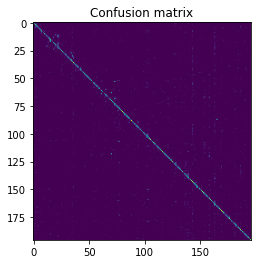

In [33]:
import sklearn.metrics
testX = testList.to_numpy()[:,0]
testY = testList.to_numpy()[:,-1] - 1

testY = keras.utils.to_categorical(testY, num_classes=196)

X = []
for path in tqdm(testX):
    img = cv.imread(pathTo(path))
    img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    X += [img]
    
X = np.array(X)
print(X.shape)

predY = model.predict(X)
predY = np.argmax(predY, axis=1)
trueY = np.argmax(testY, axis=1)

conf = sklearn.metrics.confusion_matrix(trueY, predY, normalize=None)
accuracy = sklearn.metrics.accuracy_score(trueY, predY)

print("Accuracy is: %0.2f" % (accuracy))
plt.imshow(conf)
plt.title("Confusion matrix")
plt.show()

# part 5&6

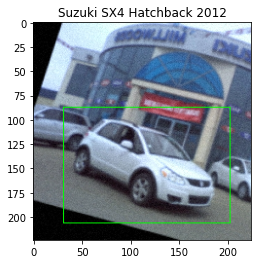

In [86]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

class Generator(keras.utils.Sequence):
    def __init__(self, data, labels, batchSize=64,\
                 dim=(224, 224), nChannels=3, nClasses=196, shuffle=True):
        ia.seed(1)
        self.dim = dim
        self.batchSize = batchSize
        self.labels = labels
        self.data = data
        self.nChannels = nChannels
        self.nClasses = nClasses
        self.shuffle = shuffle
        self.onEpochEnd()
    
    def onEpochEnd(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batchSize))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batchSize:(index+1)*self.batchSize]

        # Generate data
        X, Y = self.__dataGeneration(indexes)

        return X, Y
    
    def __scale(self, point, source, dest):
        w,h = source
        x, y = point
        x = (x/w)*dest[0]
        y = (y/h)*dest[1]
        return (int(x),int(y))
    
    def __dataGeneration(self, indexes):
        'Generates data containing batch_size samples'
        # X : (n_samples, *dim, n_channels)
        
        # Initialization
        X = np.empty((self.batchSize, * self.dim, self.nChannels), dtype=np.uint8)
        Y1 = np.empty((self.batchSize), dtype=int)
        Y2 = np.empty((self.batchSize, 4), dtype=int)
        
        # Generate data
        for i in range(self.batchSize):
            path = self.data[indexes[i]]
            img = cv.imread(pathTo(path))
            h,w = img.shape[0], img.shape[1]
            img = cv.resize(img, self.dim, interpolation = cv.INTER_AREA)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            Y1[i] = self.labels[indexes[i]][-1] - 1
            x1,y1,x2,y2 = self.labels[indexes[i]][:-1]
            x1,y1 = self.__scale((x1,y1), (w,h), self.dim)
            x2,y2 = self.__scale((x2,y2), (w,h), self.dim)
            # Augmentation
            bbs = BoundingBoxesOnImage([BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2)], self.dim)
            img, bbs = self.__agumentation((img, bbs))
            x1 = int(bbs[0].x1)
            x2 = int(bbs[0].x2)
            y1 = int(bbs[0].y1)
            y2 = int(bbs[0].y2)
            X[i,] = img
            Y2[i] = np.array([x1,y1,x2,y2])
            

        Y1 = keras.utils.to_categorical(Y1, num_classes=self.nClasses)
        
        return (X, {'output1': Y1, 'output2': Y2})
    
    def __agumentation(self, X):
        seq = iaa.Sequential([
                iaa.Fliplr(0.5), # horizontal flips
                iaa.Crop(percent=(0, 0.1)), # random crops
                # Small gaussian blur with random sigma between 0 and 0.5.
                # But we only blur about 50% of all images.
                iaa.Sometimes(
                    0.5,
                    iaa.GaussianBlur(sigma=(0, 0.5))
                ),
                # Strengthen or weaken the contrast in each image.
                iaa.LinearContrast((0.75, 1.5)),
                # Add gaussian noise.
                # For 50% of all images, we sample the noise once per pixel.
                # For the other 50% of all images, we sample the noise per pixel AND
                # channel. This can change the color (not only brightness) of the
                # pixels.
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                # Make some images brighter and some darker.
                # In 20% of all cases, we sample the multiplier once per channel,
                # which can end up changing the color of the images.
                iaa.Multiply((0.8, 1.2), per_channel=0.2),
                # Apply affine transformations to each image.
                # Scale/zoom them, translate/move them, rotate them and shear them.
                iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-25, 25),
                    shear=(-8, 8)
                )
            ], random_order=True) # apply augmenters in random order
        return seq(image=X[0], bounding_boxes=X[1])


trainX = trainList.to_numpy()[:,0]
trainY = trainList.to_numpy()[:,1:]

trainingGenerator = Generator(trainX, trainY)
X, Y = trainingGenerator[0]
img = X[0]
className = np.argmax(Y['output1'][0])
x1,y1,x2,y2 = Y['output2'][0]
img = cv.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 1)

plt.imshow(img)
plt.title(classNames[className])
plt.show()

In [91]:
from sklearn.model_selection import train_test_split

trainX = trainList.to_numpy()[:,0]
trainY = trainList.to_numpy()[:,1:]

trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=0.1, random_state=1)

trainingGenerator = Generator(trainX, trainY)
validationGenerator = Generator(validX, validY)

model= keras.applications.ResNet50(input_shape=(224,224,3),classes=196,weights='imagenet',include_top=False)
x = keras.layers.GlobalAvgPool2D()(model.output)
x = keras.layers.Dropout(0.2)(x)
output1 = keras.layers.Dense(units=196, activation='softmax', name='output1')(x)
output2 = keras.layers.Dense(units=4, activation='linear', name='output2')(x)
model = keras.models.Model(model.input, [output1, output2])
model.compile(loss={'output1':'categorical_crossentropy', 'output2': 'mean_squared_error'}, optimizer='adam', metrics=['accuracy'])

model.fit_generator(generator=trainingGenerator, validation_data=validationGenerator, epochs=10, use_multiprocessing=True, workers=-1)


Epoch 1/10
114/114 [==============================] - 147s 1s/step - loss: 6651.1367 - output1_loss: 7.0304 - output2_loss: 6644.1108 - output1_accuracy: 0.0040 - output2_accuracy: 0.6721 - val_loss: 14019.9922 - val_output1_loss: 10.2806 - val_output2_loss: 14009.7119 - val_output1_accuracy: 0.0013 - val_output2_accuracy: 0.4570
Epoch 2/10
114/114 [==============================] - 147s 1s/step - loss: 800.4067 - output1_loss: 7.1391 - output2_loss: 793.2676 - output1_accuracy: 0.0055 - output2_accuracy: 0.7867 - val_loss: 3212.0674 - val_output1_loss: 6.4706 - val_output2_loss: 3205.5967 - val_output1_accuracy: 0.0013 - val_output2_accuracy: 0.7305
Epoch 3/10
114/114 [==============================] - 145s 1s/step - loss: 550.2728 - output1_loss: 7.0797 - output2_loss: 543.1931 - output1_accuracy: 0.0053 - output2_accuracy: 0.8465 - val_loss: 1632.6962 - val_output1_loss: 6.8500 - val_output2_loss: 1625.8461 - val_output1_accuracy: 0.0039 - val_output2_accuracy: 0.8607
Epoch 4/10
114

In [ ]:
import sklearn.metrics
testX = testList.to_numpy()[:,0]
testY = testList.to_numpy()[:,-1] - 1

testY = keras.utils.to_categorical(testY, num_classes=196)

X = []
for path in tqdm(testX):
    img = cv.imread(pathTo(path))
    img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    X += [img]
    
X = np.array(X)
print(X.shape)

predY = model.predict(X)
predY = np.argmax(predY, axis=1)
trueY = np.argmax(testY, axis=1)

conf = sklearn.metrics.confusion_matrix(trueY, predY, normalize=None)
accuracy = sklearn.metrics.accuracy_score(trueY, predY)

print("Accuracy is: %0.2f" % (accuracy))
plt.imshow(conf)
plt.title("Confusion matrix")
plt.show()